# Imports

## pip install

In [1]:
!pip install onnxruntime onnx skl2onnx

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import product
# from google.colab import drive


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_rel


from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from skl2onnx import convert_sklearn
import onnxruntime as rt
import onnx

In [2]:
np.random.seed=42

## data & models

In [3]:
# data = pd.read_csv('/content/drive/MyDrive/tnv-final-project/.csv')
og_data = pd.read_csv('data/synth_data_for_training.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
model_1 = rt.InferenceSession('model/model_1_external.onnx')
model_2 = rt.InferenceSession('model/model_2_external.onnx')
# model_1 = rt.InferenceSession('model/model1.onnx')
# model_2 = rt.InferenceSession('model/model2.onnx')
model_gbc = rt.InferenceSession('model/gboost.onnx')

# Utils

# Test-Cases

In [13]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Print size of train and test
print(X_train.shape, X_test.shape)




def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue

        t = FloatTensorType([None, 1])

        inputs.append((k, t))
    return inputs


initial_inputs = convert_dataframe_schema(X_train)


inputs = {c: X_test[c].values for c in X_test.columns}
for (c, _) in initial_inputs:
    inputs[c] = inputs[c].astype(np.float32)
for k in inputs:
    inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))


#### OLD:
# y_test_data_from_training = test_data['checked']
# X_test_data_from_training = test_data.copy(deep=True).astype(np.float32)
# X_test_data_from_training.drop('checked', axis=1, inplace=True)
# X_test_data_from_training

(9483, 315) (3162, 315)


# Differential Tests

#### Test on different models

In [16]:
def compute_false_positives_and_negatives(predictions, truths):
    if len(predictions) != len(truths):
        return "Arrays must be of the same size"
    
    predictions = np.array(predictions)
    truths = np.array(truths)
    
    false_positives = np.sum(np.logical_and(predictions == 1, truths == 0))
    false_negatives = np.sum(np.logical_and(predictions == 0, truths == 1))
    
    return false_positives, false_negatives 

In [27]:
# pred_dif = {}
# pred_to_y_dist  = {}
# pred_to_y_cat= {}

def weird_data_transform(data):
  inputs = {c: data[c].values for c in data.columns}
  for (c, _) in initial_inputs:
      inputs[c] = inputs[c].astype(np.float32)
  for k in inputs:
      inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))
  return inputs
  

def feature_effect(model, data, feature: str, feature_type: str, values=None, dicts=None):

  if feature not in data.columns:
    raise ValueError(f"The feature '{feature}' is not found in the data.")
  

  if feature_type == 'numeric':
    predictions1, predictions2 = [], []
    start, end = values[0], values[1]
    test_data = data.copy(deep=True)
    test_data[feature] = start
    predictions1 = model.run(None, weird_data_transform(test_data))[0]
    test_data[feature] = end
    predictions2 = model.run(None, weird_data_transform(test_data))[0]
    fp, fn = compute_false_positives_and_negatives(predictions2, y_test)
    print(fp, fn)
    # dicts[0][(feature, start, sum(abs(predictions1 - y_test)) , end, sum(abs(predictions2 - y_test)))] = abs(sum(abs(predictions1 - y_test)) - sum(abs(predictions2 - y_test)))
    # dicts[0][(feature, end, 'max')] = sum(abs(predictions2 - y_test_data_from_training))
    
    # dicts[1][feature] = sum(abs(predictions1 - predictions2)) / len(predictions1)
    # print("FPFN: \n",feature, "\n", compute_false_positives_and_negatives(predictions1, y_test))
    # dicts[2][feature, np.sum(np.logical_and(predictions1 == 1, predictions2 == 1)), np.sum(np.logical_and(predictions1 == 0, predictions2 == 0)), \
    #          np.sum(np.logical_and(predictions1 == 1, predictions2 == 0)), np.sum(np.logical_and(predictions1 == 0, predictions2 == 1))] = abs(sum(abs(predictions1 - y_test)) - sum(abs(predictions2 - y_test)))



In [20]:
feature_importances = pd.read_csv('features.csv', encoding='latin-1')

In [21]:
sorted_features = feature_importances.sort_values(by='relative_importance', ascending=False)
numeric_features = [feature for feature, dtype in zip(sorted_features['feature'], sorted_features['datatype']) if dtype in ('int', 'float')]

In [22]:
m1_pred_dif = {}
m1_pred_to_y_dist  = {}
m1_pred_to_y_cat= {}

m2_pred_dif = {}
m2_pred_to_y_dist  = {}
m2_pred_to_y_cat= {}

for val in tqdm(numeric_features):
  max = X_test[val].max()
  min = X_test[val].min()
  feature_effect(model_1, X_test, val, 'numeric', values = (min, max), dicts = (m1_pred_dif ,m1_pred_to_y_dist, m1_pred_to_y_cat))
  feature_effect(model_2, X_test, val, 'numeric', values = (min, max), dicts = (m2_pred_dif, m2_pred_to_y_dist, m2_pred_to_y_cat))



100%|██████████| 315/315 [01:03<00:00,  4.93it/s]


In [103]:
counter = 0
# print(len(m2_pred_y_to_dist))
for v in m2_pred_to_y_dist.values():
  # if v > 0.05:
  counter += 1
  # else:
  #   print(v)
print(counter)

315


# Values Distribution

In [23]:
print({k: v for k, v in sorted(m1_pred_dif.items(), key=lambda item: item[1], reverse = True)})
print({k: v for k, v in sorted(m2_pred_dif.items(), key=lambda item: item[1], reverse = True)})

print({k: v for k, v in sorted(m1_pred_to_y_dist.items(), key=lambda item: item[1], reverse = True)})
print({k: v for k, v in sorted(m2_pred_to_y_dist.items(), key=lambda item: item[1], reverse = True)})

# print({k: v for k, v in sorted(pred_to_y_cat.items(), key=lambda item: item[1], reverse = True)})

{('contacten_onderwerp_no_show', 0.0, 251, 5.0, 461): 210, ('contacten_soort_afgelopenjaar_document__uitgaand_', 0.0, 228, 26.0, 437): 209, ('relatie_overig_actueel_vorm__kostendeler', 0.0, 237, 4.0, 444): 207, ('relatie_kind_jongvolwassen', 0.0, 234, 4.0, 285): 51, ('adres_recentste_buurt_groot_ijsselmonde', 0.0, 244, 1.0, 290): 46, ('contacten_onderwerp_overleg_met_inkomen', 0.0, 241, 5.0, 281): 40, ('relatie_overig_historie_vorm__andere_inwonende', 0.0, 239, 3.0, 277): 38, ('competentie_plannen_en_organiseren', 0.0, 237, 2.0, 272): 35, ('contacten_onderwerp_inkomen', 0.0, 233, 4.0, 262): 29, ('pla_einde_uitstroom_anders_dan_volgen_onderwijs__regulier_werk_of_als_zelfstandige', 0.0, 241, 2.0, 268): 27, ('contacten_onderwerp_ziek__of_afmelding', 0.0, 235, 6.0, 262): 27, ('contacten_soort_telefoontje__inkomend_', 0.0, 260, 19.0, 234): 26, ('belemmering_dagen_financiele_problemen', -10985.0, 236, 10489.0, 261): 25, ('instrument_reden_beeindiging_historie_uitval__klant_wz__ziet_af_van_aa

In [86]:
sorted_list_m1 = sorted(m1_pred_to_y_dist.items(), key=lambda item: item[1], reverse = True)
sorted_list_m2 = sorted(m2_pred_to_y_dist.items(), key=lambda item: item[1], reverse = True)

fpfn_dict = {}
for i in range(5):
    feature = sorted_list_m1[i][0]
    min = X_test[feature].min()
    max = X_test[feature].max()
    print("Feature:", feature)
    max_false = 0, 0, 0, 0
    arr_false = []
    arr_e = []
    arr_fp = []
    arr_fn = []
    if i >= 3:
        continue
    for e in range(int(min), int(max) + 1):
        test_data = X_test.copy(deep=True)
        test_data[feature] = e
        predictions = model_1.run(None, weird_data_transform(test_data))[0]
        fp, fn = compute_false_positives_and_negatives(predictions, y_test)
        arr_false.append(fp+fn)
        arr_e.append(e)
        arr_fp.append(fp)
        arr_fn.append(fn)

        if fp + fn > max_false[0]:
            max_false = fp + fn, e, fp, fn
        # print(fp, fn)
        # if e > 100:
        #     break
    fpfn_dict[feature] = max_false, arr_e, arr_false, arr_fp, arr_fn
# print(fpfn_dict)

# for 
# Now i want to go over a range of different values this feature can take and calculate the amount of false positives and false negatives. 

Feature: contacten_onderwerp_no_show
Feature: relatie_overig_actueel_vorm__kostendeler
Feature: contacten_soort_afgelopenjaar_document__uitgaand_
Feature: ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden
Feature: persoonlijke_eigenschappen_dagen_sinds_taaleis


contacten_onderwerp_no_show (461, 5, 396, 65)


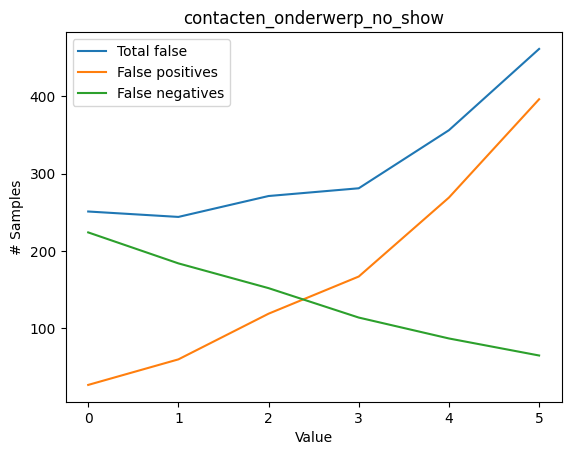

relatie_overig_actueel_vorm__kostendeler (444, 4, 371, 73)


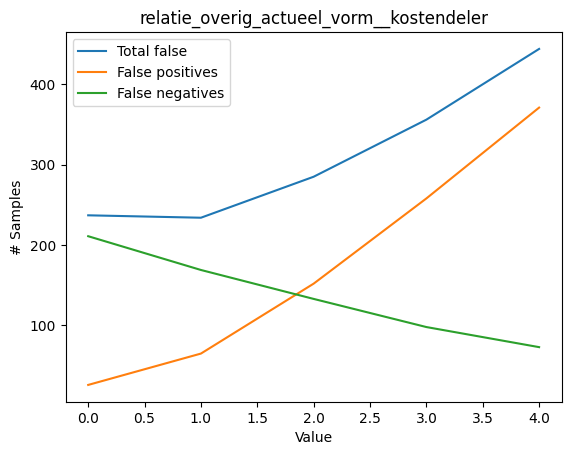

contacten_soort_afgelopenjaar_document__uitgaand_ (437, 26, 373, 64)


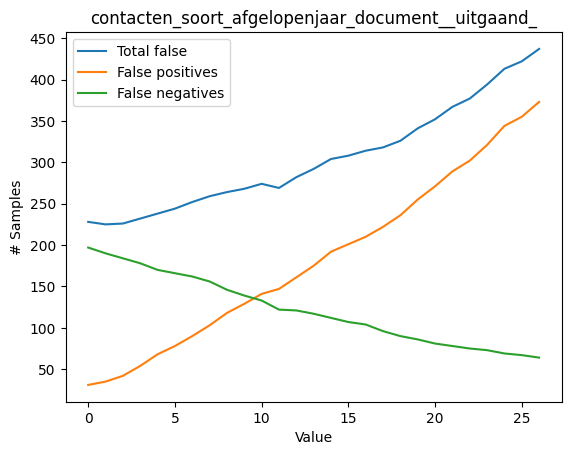

In [87]:
for k,v in fpfn_dict.items():
    print(k, v[0])
    plt.plot(v[1], v[2], label='Total false')
    plt.plot(v[1], v[3], label='False positives')
    plt.plot(v[1], v[4], label ='False negatives')
    plt.xlabel('Value')
    plt.ylabel('# Samples')
    plt.title(k)
    plt.legend()
    plt.show()



#